In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_csv('weight-height.csv')
data.columns = ['gender', 'height', 'weight']
#data.loc[data['gender'] == 'Male', 'gender'] = 0
#data.loc[data['gender'] == 'Female', 'gender'] = 1

sub_data = data.sample(1000, random_state=1)
features = sub_data.drop('gender', axis=1)
target = sub_data['gender']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25)
(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)

((750, 2), (250, 2), (750,), (250,))

In [9]:
pd.Series([None] * len(features_valid.index), index=features_valid.index)

4649    None
7956    None
6355    None
1987    None
9929    None
        ... 
736     None
8651    None
3770    None
7359    None
6214    None
Length: 250, dtype: object

In [144]:
class TreeNode():

    left = None
    right = None

    def __init__(self, feature_index = None, feature_threshold = 0, impurity = 0, is_left = None, depth = 0, nsamples=0, hindex=0, clazz=None, clazz_percentage=0):
        self.feature_index = feature_index
        self.feature_threshold = feature_threshold
        self.is_left = is_left
        self.impurity = impurity
        self.depth = depth
        self.nsamples = nsamples
        self.hindex = hindex
        self.clazz = clazz
        self.clazz_percentage = clazz_percentage

    def graph_id(self):
        return f'{self.depth}d{self.hindex}h'

    def __str__(self):
        if self.depth == 0:
            return 'root node impurity = {:.2f}, nsamples {:}'.format(self.impurity, self.nsamples)

        return '{:} {:} {:.2f}, impurity {:.2f}\ndepth {:}, hindex {:}, nsamples {:}\nclass {:} {:0.2%}'.format(self.feature_index, "<" if self.is_left else ">=", self.feature_threshold, self.impurity, self.depth, self.hindex, self.nsamples, self.clazz, self.clazz_percentage)


class CustomDecisionTree():

    # leaf (also called external node) and an internal node. 
    # An internal node will have further splits (also called children), 
    # while a leaf is by definition a node without any children (without any further splits).


    # The maximum depth of the tree. 

    # The min_samples_split parameter will evaluate the number of
    # samples in the node, and if the number is less than the minimum 
    # the split will be avoided and the node will be a leaf.

    # The min_samples_leaf parameter checks before the node is generated, that is,
    # if the possible split results in a child with fewer samples, the split will be avoided 
    # (since the minimum number of samples for the child to be a leaf has not been reached) and the node will be replaced by a leaf.

    # TODO:
    # 0. Module structure
    # 1. splitter=best|random (better way to split)
    # 2. min_impurity_decrease
    # 3. criterion=gini|entropy
    # 4. class_weight
    # 5. PREDICT and measure the result
    # 6. RandomForest 

    def __init__(self, max_depth=32, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf


    def calc_entropy_for_class(self, sample, total_samples):
        if total_samples == 0:
            return 0

        p = sample / total_samples

        return -p * np.log2(p)

    def calc_entropy(self, samples, total_samples):
        return sum([self.calc_entropy_for_class(x, total_samples) for x in samples])


    def calc_gini(self, samples, total_samples):

        gini = 0
        for sample in samples:
            gini += self.calc_gini_for_class(sample, total_samples)

        return gini

    def calc_gini_for_class(self, sample, total_samples):
        if total_samples == 0:
            return 0
        p = sample / total_samples

        return p * (1 - p)

    def calc_impurity_for_class(self, sample, total_samples):
        return self.calc_entropy_for_class(sample, total_samples) if self.criterion == 'entropy' else self.calc_gini_for_class(sample, total_samples)


    def fit(self, features, target):

        self.classes = target.unique()
        value_counts = target.value_counts()

        # it makes value_count in a good order
        self.root_samples = [value_counts[self.classes[x]] for x in range(0, len(value_counts))]

        total_samples = len(target)
        root_impurity = self.calc_entropy(self.root_samples, total_samples) if self.criterion == 'entropy' else self.calc_gini(self.root_samples,total_samples)

        self.root_node = TreeNode(impurity = root_impurity, nsamples=total_samples)
        self.current_depth = 0
        self.split_inner_node(self.root_node, features, target)

        return (self.root_node, self.current_depth)


    def split_inner_node(self, node, features, targets):

        if node.clazz_percentage == 1:
            print(f'stop because we dont have more classes to separate {node}')
            return False

        if len(targets) < self.min_samples_split:
            print(f'stop because of min_samples_split {node}')
            return False

        if node.depth >= self.max_depth:
            print(f'stop because of max_depth {node}')
            return False


        min_impurity_left, min_impurity_right, found_threshold, found_feature_index, features_left, features_right, targets_left, targets_right = self.find_best_impurity(features, target)

        impurity_gain = node.impurity - min_impurity_left - min_impurity_right

        print(f'found best impurity gain = {impurity_gain}, found_threshold = {found_threshold}, feature {found_feature_index}, new depth = {node.depth + 1} current node is left {node.is_left}')


        if targets_left is None or targets_right is None or self.min_samples_leaf > len(targets_left) or self.min_samples_leaf > len(targets_right):

            left_counts = targets_left.value_counts() if targets_left is not None else None
            right_counts = targets_right.value_counts() if targets_right is not None else None

            print(f'stop because of min_samples_leaf {node} left:\n{left_counts}\nright:\n{right_counts}')
            return False

        new_depth = node.depth + 1

        if self.current_depth < new_depth:
            self.current_depth = new_depth

        
        left_clazz, left_clazz_percentage = self.get_clazz_and_its_percentage(targets_left)
        node.left = TreeNode(feature_index = found_feature_index, feature_threshold = found_threshold, impurity = min_impurity_left, is_left = True, depth = new_depth, nsamples=len(targets_left), hindex=node.hindex * 2, clazz=left_clazz, clazz_percentage=left_clazz_percentage)
        self.split_inner_node(node.left, features_left, targets_left)

        right_clazz, right_clazz_percentage = self.get_clazz_and_its_percentage(targets_right)
        node.right = TreeNode(feature_index = found_feature_index, feature_threshold = found_threshold, impurity = min_impurity_right, is_left = False, depth = new_depth, nsamples=len(targets_right), hindex=node.hindex*2 + 1, clazz=right_clazz, clazz_percentage=right_clazz_percentage)
        self.split_inner_node(node.right, features_right, targets_right)
        
        return True

    def get_clazz_and_its_percentage(self, targets_left):
        left_value_counts = targets_left.value_counts()
        left_clazz = left_value_counts.index[left_value_counts.argmax()]
        left_clazz_percentage = left_value_counts[left_clazz] / left_value_counts.sum()
        return (left_clazz, left_clazz_percentage)


    def find_best_impurity(self, features, targets):

        min_impurity_left = 1000000
        min_impurity_right = 1000000
        found_threshold = 0
        found_feature_index = None
        features_left = None
        features_right = None
        targets_right = None
        targets_left = None


        for feature in features:
            impurity_left, impurity_right, threshold, features_less, features_more, targets_less, targets_more = self.find_best_impurity_for_feature(features, feature, targets)

            if min_impurity_left + min_impurity_right > impurity_left + impurity_right:
                min_impurity_left = impurity_left
                min_impurity_right = impurity_right
                found_threshold = threshold
                found_feature_index = feature

                features_left = features_less
                features_right = features_more
                targets_left = targets_less
                targets_right = targets_more

        
        return (min_impurity_left, min_impurity_right, found_threshold, found_feature_index, features_left, features_right, targets_left, targets_right)



    def find_best_impurity_for_feature(self, features, feature_index, targets):

        total_samples = features.shape[0]
        unique =  np.sort(features[feature_index].unique())

        min_impurity_left = 1000000
        min_impurity_right = 1000000
        features_left = None
        features_right = None
        targets_right = None
        targets_left = None
        found_threshold = 0

        for index in range(1, len(unique)):

            threshold = unique[index]

            features_more = features[features[feature_index] >= threshold]
            features_less = features[features[feature_index] < threshold]
            targets_more = targets[features_more.index]
            targets_less = targets[features_less.index]

            left_impurity = 0
            right_impurity = 0
            for c in self.classes:
                left_impurity += self.calc_impurity_for_class(targets_less[targets_less == c].shape[0], targets_less.shape[0])
                right_impurity += self.calc_impurity_for_class(targets_more[targets_more == c].shape[0], targets_more.shape[0])

            total_samples = len(targets_more) + len(targets_less)
            left_impurity = (left_impurity * len(targets_less)) / total_samples
            right_impurity = (right_impurity * len(targets_more)) / total_samples

            if left_impurity + right_impurity < (min_impurity_left + min_impurity_right):
                min_impurity_left = left_impurity
                min_impurity_right = right_impurity
                found_threshold = threshold
                features_left = features_less
                features_right = features_more
                targets_left = targets_less
                targets_right = targets_more

        return (min_impurity_left, min_impurity_right, found_threshold, features_left, features_right, targets_left, targets_right)


    def predict(self, features):
        pass


In [150]:
import graphviz

color_classes = {'Male': 'blue', 'Female': 'red'}

def visualize_children(dot, root_node):
    if root_node.left is not None and root_node.right is not None:

        
        dot.attr('node', shape='rectangle', color=color_classes[root_node.left.clazz])
        dot.node(root_node.left.graph_id(), root_node.left.__str__())

        dot.attr('node', shape='rectangle', color=color_classes[root_node.right.clazz])
        dot.node(root_node.right.graph_id(), root_node.right.__str__())

        dot.edge(root_node.graph_id(), root_node.left.graph_id())
        dot.edge(root_node.graph_id(), root_node.right.graph_id())

        visualize_children(dot, root_node.left)
        visualize_children(dot, root_node.right)

def visualize_result(root_node, save_pdf=False):

    dot = graphviz.Digraph(comment='decision_tree')
    dot.attr('node', shape='rectangle')
    dot.node(root_node.graph_id(), root_node.__str__())

    visualize_children(dot, root_node)

    if save_pdf:
        dot.render('decision_tree_output', view=True)  

    return dot

In [145]:
model = CustomDecisionTree(max_depth=10)
model.fit(features_train, target_train)

 feature height, new depth = 9 current node is left False
stop because we dont have more classes to separate height < 64.94, gini 0.00
depth 9, hindex 98, nsamples 14
class Female 100.00%
found best gini. gini_gain = -0.04444444444444448 min_gini_left 0.0, min_gini_right 0.1777777777777778, found_threshold = 65.15222843663399, feature height, new depth = 10 current node is left False
stop because we dont have more classes to separate height < 65.15, gini 0.00
depth 10, hindex 198, nsamples 1
class Male 100.00%
stop because of max_depth height >= 65.15, gini 0.18
depth 10, hindex 199, nsamples 9
class Female 88.89%
found best gini. gini_gain = -0.15555555555555556 min_gini_left 0.26666666666666666, min_gini_right 0.0, found_threshold = 149.402546671129, feature weight, new depth = 8 current node is left False
found best gini. gini_gain = -0.13333333333333336 min_gini_left 0.0, min_gini_right 0.4, found_threshold = 64.26199957133831, feature height, new depth = 9 current node is left Tru

(<__main__.TreeLeaf at 0x20034082100>, 10)

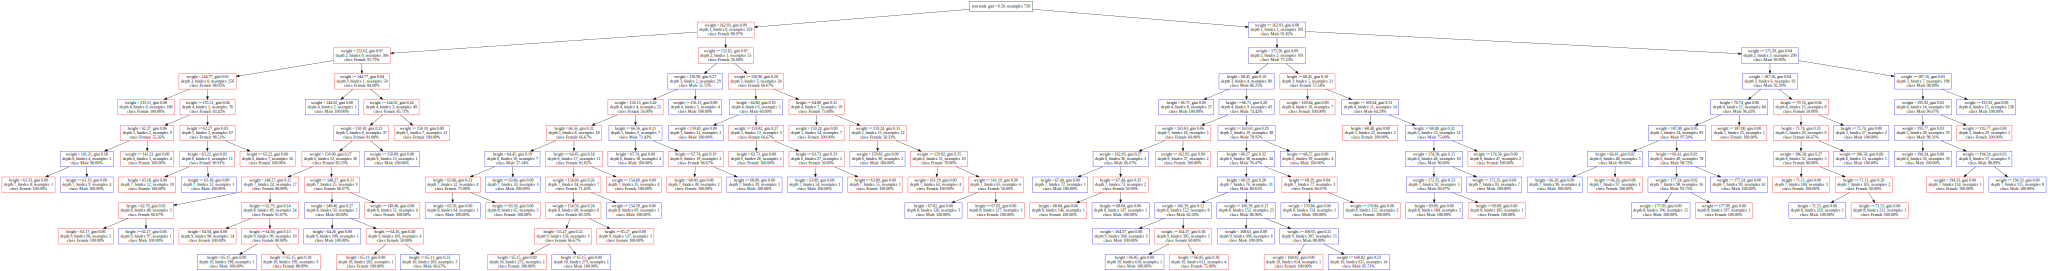

In [152]:
visualize_result(model.root_node, save_pdf=False)